In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Section 0: Sample Complexity as a Function of samples

In [ ]:
# parameters
delta = 0.99

3.876714207552249 2.4518493466799676


In [ ]:
def f_simp(c1, c2, n, gamma):
  alpha = np.sqrt(1/(n*(1-gamma)))
  beta = np.sqrt(1/(n*gamma))
  return 1 + 3*c1*alpha + 2*np.sqrt(c2*beta + 3*c1*alpha), 3*c1*alpha, 2*np.sqrt(c2*beta + 3*c1*alpha)

0.5929576360978274 2.4518493466799676
2.4044934127834217 2.4518493466799676
3.876714207552249 2.4518493466799676


(0.0, 10.0)

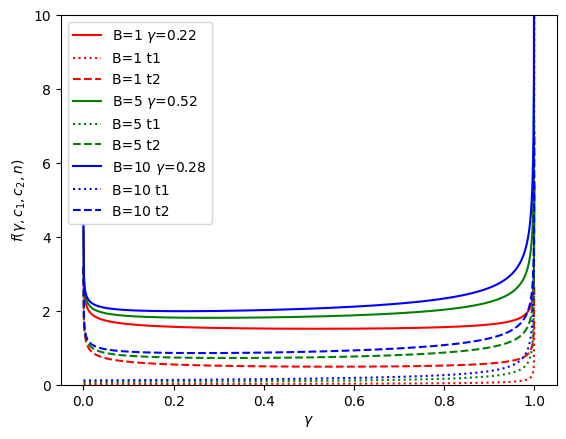

In [ ]:
n = 10000

gamma = np.linspace(1e-4, 1-1e-4, 1000)
B = 10
F = 10
for B, c in zip([1, 5, 10], ['r', 'g', 'b']): #, 25, 100]:
  c1 = np.sqrt(B*np.log((2*B)/delta)/2)
  c2 = np.sqrt(2*np.log((2*F)/delta))
  print(c1, c2)

  f_arr, f_alpha, f_beta = f_simp(c1, c2, n, gamma)

  plt.plot(gamma, f_arr, label=f"B={B} $\gamma$={opt:.2f}", c=c)
  plt.plot(gamma, f_alpha, label=f"B={B} t1", linestyle=":", c=c)
  plt.plot(gamma, f_beta, label=f"B={B} t2", linestyle="--", c=c)
  opt = gamma[np.argmin(f_arr)]
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$f(\gamma, c_1, c_2, n)$")
plt.ylim(0, 10)

3.876714207552249 1.1859152721956547
3.876714207552249 2.150644288973677
3.876714207552249 2.4518493466799676
3.876714207552249 2.800740381142689
3.876714207552249 3.258333224948467


(0.0, 10.0)

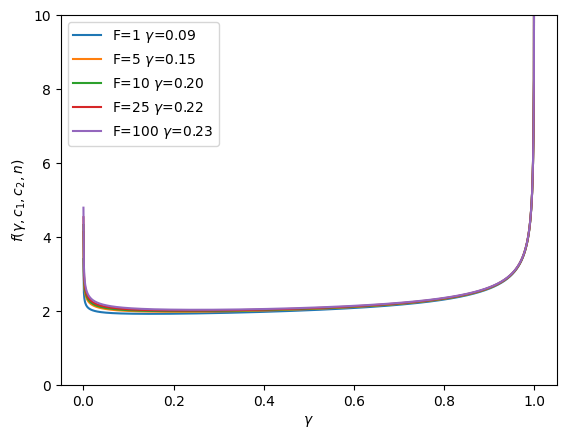

In [ ]:
B=10
for F in [1, 5, 10, 25, 100]:
  c1 = np.sqrt(B*np.log((2*B)/delta)/2)
  c2 = np.sqrt(2*np.log((2*F)/delta))
  print(c1, c2)

  f_arr = f_simp(c1, c2, n, gamma)
  plt.plot(gamma, f_arr, label=f"F={F} $\gamma$={opt:.2f}")
  opt = gamma[np.argmin(f_arr)]
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$f(\gamma, c_1, c_2, n)$")
plt.ylim(0, 10)

3.876714207552249 2.4518493466799676
3.876714207552249 2.4518493466799676
3.876714207552249 2.4518493466799676
3.876714207552249 2.4518493466799676
3.876714207552249 2.4518493466799676


(0.0, 10.0)

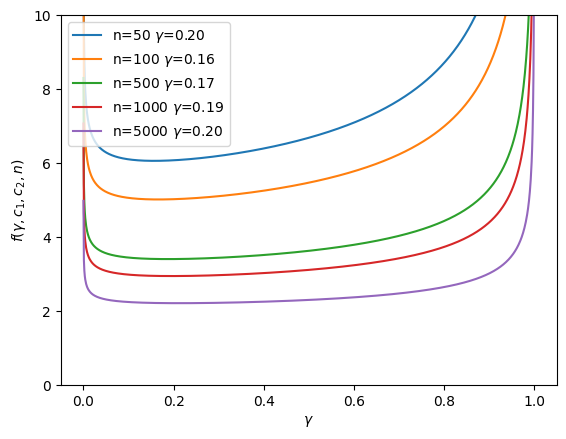

In [ ]:
B=10
F=10
for n in [50, 100, 500, 1000, 5000]:
  c1 = np.sqrt(B*np.log((2*B)/delta)/2)
  c2 = np.sqrt(2*np.log((2*F)/delta))
  print(c1, c2)

  f_arr = f_simp(c1, c2, n, gamma)
  plt.plot(gamma, f_arr, label=f"n={n} $\gamma$={opt:.2f}")
  opt = gamma[np.argmin(f_arr)]
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$f(\gamma, c_1, c_2, n)$")
plt.ylim(0, 10)

## Section 1: Samples with for fitting and calibration

Number of total samples:    30000
Number of positive samples: 6636


In [ ]:

def reliability_diagram(y_true, y_pred, N=20):
    paired = np.c_[y_pred, y_true]
    paired = paired[np.argsort(paired[:,0])]
    length = paired.shape[0]
    mean_proba, mean_true = [], []
    start_idx = 0
    size = int(np.ceil(length/N))
    while start_idx < length:
        mean_proba.append(paired[start_idx:start_idx+size, 0].mean())
        mean_true.append(paired[start_idx:start_idx+size, 1].mean())
        start_idx += size

    ece_l1 = 0
    ece_l2 = 0
    for i in range(len(mean_proba)):
      ece_l1 += 1/size*np.abs(mean_proba[i] - mean_true[i])
      ece_l2 += 1/size*np.square(mean_proba[i] - mean_true[i])

    return mean_proba, mean_true, ece_l1, ece_l2



In [ ]:
reliab_plot = {}
B=10
for clf, clf_name in clfs:
  model = clf.fit(X_train, y_train)
  mean_proba, mean_true, K1, K2 = expected_calibration_error(np.asarray(y_test), clf.predict_proba(X_test)[:, 1], num_bins=B)
  #mean_proba, mean_true, K1, K2 = reliability_diagram(y_test, clf.predict_proba(X_test)[:, 1])
  print('AUC on train set:    {:6.3f}'.format(
  roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])))
  print('AUC on test set:     {:6.3f}'.format(
  roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
  print(f'K1 error {K1} K2 error {K2}')
  reliab_plot[clf_name] = (mean_proba, mean_true)

NameError: name 'X_train' is not defined

Text(0, 0.5, '$E[y]$')

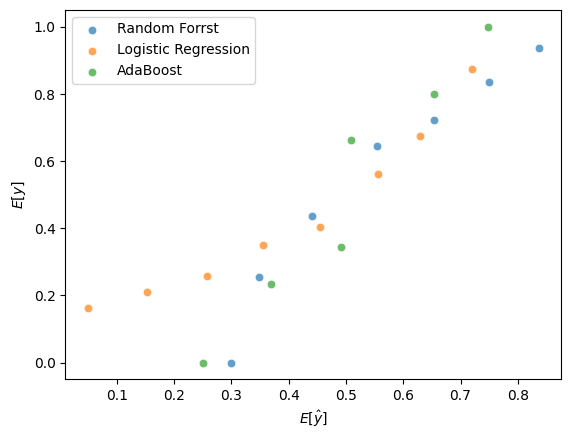

In [ ]:
for name in reliab_plot.keys():
  mean_proba, mean_true = reliab_plot[name]
  sns.scatterplot(x=mean_proba, y=mean_true, alpha=0.7, label=name)

plt.plot()
plt.xlabel(r"$E[\hat{y}]$")
plt.ylabel(r"$E[y]$")

In [ ]:
clfs = [
    (GradientBoostingClassifier(n_estimators=50), 'Gradient Boosting'),
    (LogisticRegression(), 'Logistic Regression'),
    (AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=5), 'AdaBoost'),
]

reliab_plot = {}
results = []
gamma = 0.5

B = 50
num_iter = 10
for clf, clf_name in clfs:
  for gamma in np.linspace(0.1, 0.9, 10):
    for run in range(5):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
      X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=gamma)
      n_tot = len(y_train) + len(y_cal)
      # original clf
      clf.fit(X_train, y_train)
      y_pred = clf.predict_proba(X_test)[:, 1]
      mean_proba, mean_true, K1, K2 = expected_calibration_error(np.asarray(y_test),
                                                                y_pred, num_bins=B)
      mse = mean_squared_error(y_pred, y_test)
      reliab_plot[clf_name] = (mean_proba, mean_true)

      auc = roc_auc_score(y_test, y_pred)
      print('Uncalibrated')
      print('AUC on test set:     {:6.3f}'.format(auc))
      print(f'K1 error {K1} K2 error {K2}')

      # bin calibration
      intervals, values = bin_calibrate(X_cal, y_cal, clf, B)
      y_pred = calibrated_mapping(y_pred, intervals, values)
      mean_proba, mean_true, K1_c, K2_c = expected_calibration_error(np.asarray(y_test),
                                                                    y_pred, num_bins=B)
      auc_c = roc_auc_score(y_test, y_pred)
      mse_c = mean_squared_error(y_pred, y_test)
      print('Calibrated')
      print('AUC on test set:     {:6.3f}'.format(auc_c))
      print(f'K1 error {K1_c} K2 error {K2_c}')
      reliab_plot[f"{clf_name} binned"] = (mean_proba, mean_true)

      results.append({
          'test_AUC': auc,
          'test_mse': mse,
          'test_K1': K1,
          'test_K2': K2,
          'binned_test_AUC': auc_c,
          'binned_test_mse': mse_c,
          'binned_test_K1': K1_c,
          'binned_test_K2': K2_c,
          'clf': clf_name,
          'gamma': gamma,
          'B': B

      })
  break

Uncalibrated
AUC on test set:      0.786
K1 error 0.04095695310161905 K2 error 0.0024965379654782903
Calibrated
AUC on test set:      0.731
K1 error 0.07467491704779841 K2 error 0.012588674261992656
Uncalibrated
AUC on test set:      0.782
K1 error 0.043931380735668796 K2 error 0.0030344539366240365
Calibrated
AUC on test set:      0.745
K1 error 0.07485916468967317 K2 error 0.01088126267728854
Uncalibrated
AUC on test set:      0.778
K1 error 0.041294022238469064 K2 error 0.0031571446621655916
Calibrated
AUC on test set:      0.723
K1 error 0.0909506689167706 K2 error 0.016980441090745348
Uncalibrated
AUC on test set:      0.768
K1 error 0.041191428936837804 K2 error 0.002812660298041678
Calibrated
AUC on test set:      0.719
K1 error 0.07260090819412851 K2 error 0.010536268317403365
Uncalibrated
AUC on test set:      0.763
K1 error 0.04564277028825699 K2 error 0.0037581635194323055
Calibrated
AUC on test set:      0.719
K1 error 0.10165659826676776 K2 error 0.013449787622399864
Uncal

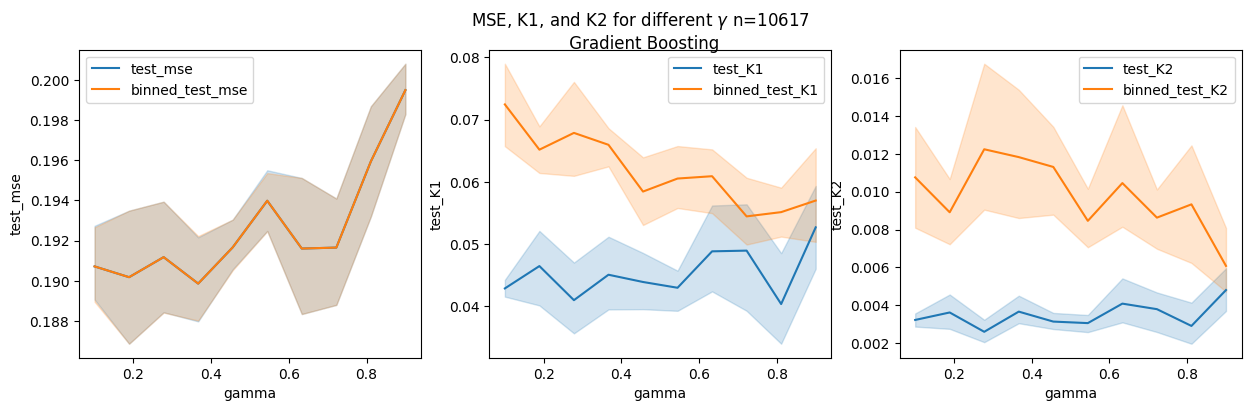

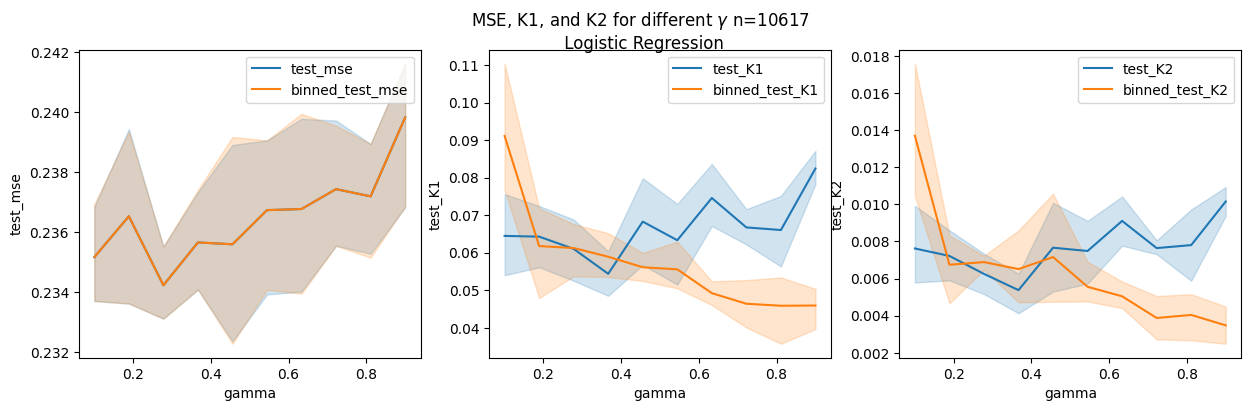

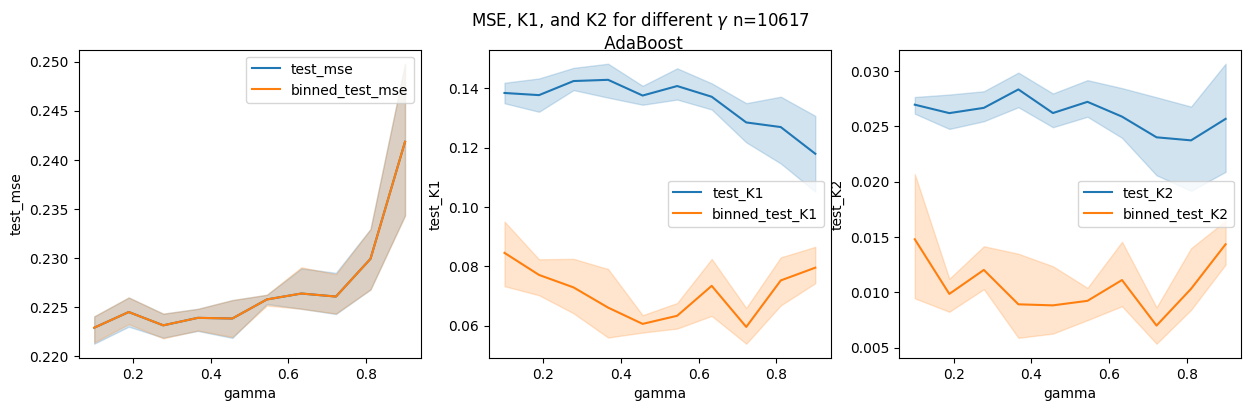

Text(0, 0.5, '$E[y]$')

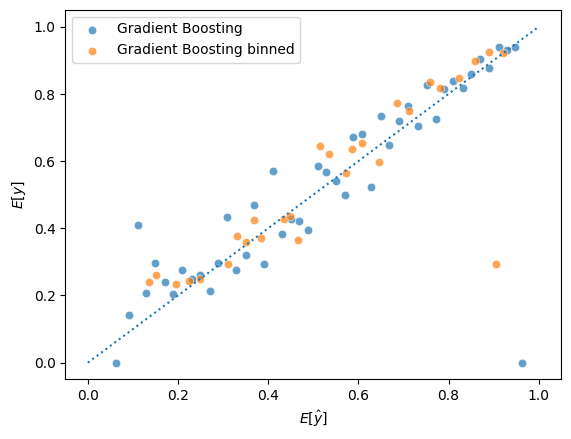

In [ ]:
clf_name = "Gradient Boosting"
for name in [clf_name, f"{clf_name} binned"]:
  mean_proba, mean_true = reliab_plot[name]
  sns.scatterplot(x=mean_proba, y=mean_true, alpha=0.7, label=name)

plt.plot([0, 1], [0, 1], label="y=x", linestyle=":")
plt.xlabel(r"$E[\hat{y}]$")
plt.ylabel(r"$E[y]$")